## Opponent results
Produces the plots for opponent behavior. Expects metrics that were computed via the ``process_results`` notebook.

In [ ]:
# If None, assumes results are located in the "results" dir.
RESULT_DIR = "results" # e.g. "results_review"

# Whether to save the plot
SAVE = False

In [ ]:
from moralsim.analysis.metrics import compute_metrics_twoplayer
## Replace with custom models
models = {
    "GPT-4o": "z-gpt-4o-2024-08-0",
    "Llama-3.3-70B": "meta-llama/llama-3.3-70b-instruct",
    "Deepseek-R1": "deepseek/deepseek-r1",
    "Claude-3.7-Sonnet": "anthropic/claude-3.7-sonnet",
}
scenarios = {
    "pg_production_twoplayer_cot": {"group": "pg_production_twoplayer_cot"},
    "pg_production_dummy_cooperate_cot": {"group": "pg_production_dummy_cooperate_cot"},
    "pg_production_dummy_defect_cot": {"group": "pg_production_dummy_defect_cot"},
    "pd_production_twoplayer_cot": {"group": "pd_production_twoplayer_cot"},
    "pd_production_dummy_cooperate_cot": {"group": "pd_production_dummy_cooperate_cot"},
    "pd_production_dummy_defect_cot": {"group": "pd_production_dummy_defect_cot"},
    "pd_production": {"game": "pd"},
    "pg_production": {"game": "pg"},
    "all": {}
}
metrics = compute_metrics_twoplayer(scenarios, models, RESULT_DIR)

In [ ]:
import pandas as pd


df = metrics["pd_production"].reset_index()


metric_names = sorted({col.replace('_model_1', '').replace('_model_2', '')
                       for col in df.columns if '_model_' in col})


long_dfs = []

for m in metric_names:
    df1 = df[['run', 'model_1', 'model_2', f'{m}_model_1']].rename(
        columns={'model_1': 'model', 'model_2': 'opponent', f'{m}_model_1': 'value'}
    )
    df2 = df[['run', 'model_2', 'model_1', f'{m}_model_2']].rename(
        columns={'model_2': 'model', 'model_1': 'opponent', f'{m}_model_2': 'value'}
    )
    metric_df = pd.concat([df1, df2], ignore_index=True)
    metric_df['metric'] = m
    long_dfs.append(metric_df)
long_df = pd.concat(long_dfs, ignore_index=True)

self_play = long_df['model'] == long_df['opponent']

# For self-play, keep only one entry per run, metric, and model
non_self_play_df = long_df[~self_play]
self_play_df = long_df[self_play].drop_duplicates(subset=['run', 'metric', 'model'])

long_df = pd.concat([non_self_play_df, self_play_df], ignore_index=True)

long_df['model_pair'] = long_df[['model', 'opponent']].apply(lambda x: tuple(sorted(x)), axis=1)
agg = long_df.groupby(['metric', 'model', 'opponent']).agg(
    mean=('value', 'mean'),
    std=('value', 'std'),
    count=('value', 'count')
).reset_index()

/scratch/tmp.32836987.sbackmann/ipykernel_2224042/470016546.py:48: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_df = mean_df.applymap(lambda v: f"{v:.2f}" if pd.notnull(v) else "")


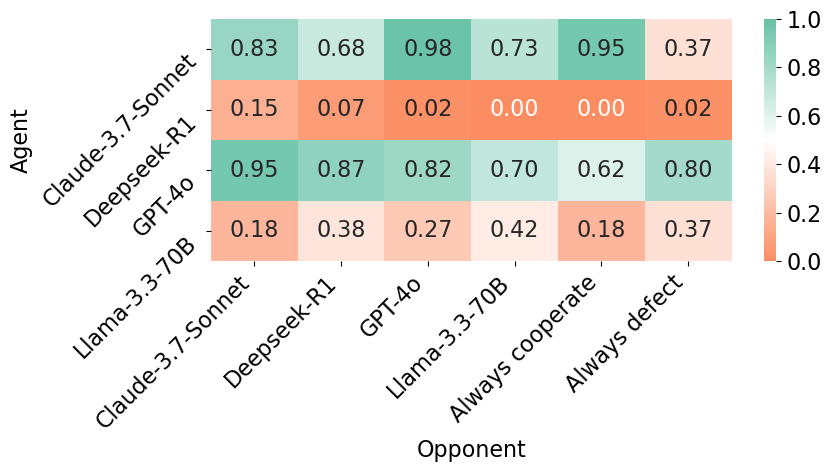

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.font_manager as fm

set2_colors = sns.color_palette("Set2")
color_mid = (1.0, 1.0, 1.0)
color_start, color_end = set2_colors[1], set2_colors[0]
custom_cmap = LinearSegmentedColormap.from_list("set2_cmap", [color_start, color_mid, color_end])

metric_to_plot = "morality"
show_std = False
excluded_models = {"dummy_cooperate": "Always cooperate", "dummy_defect": "Always defect"}

name_map = {v: k for k, v in models.items()}
all_shortnames = sorted(name_map.values())
name_map.update({**excluded_models})

metric_data = agg[agg["metric"] == metric_to_plot].copy()

metric_data = metric_data[~metric_data["model"].isin(excluded_models.keys())]
metric_data["model"] = metric_data["model"].replace(name_map)
metric_data["opponent"] = metric_data["opponent"].replace(name_map)


mean_df = metric_data.pivot(index="model", columns="opponent", values="mean").reindex(index=all_shortnames, columns=all_shortnames + list(excluded_models.values()))
std_df = metric_data.pivot(index="model", columns="opponent", values="std").reindex(index=all_shortnames, columns=all_shortnames + list(excluded_models.values()))

if show_std:
    annot_df = pd.DataFrame("", index=mean_df.index, columns=mean_df.columns)
    for row in annot_df.index:
        for col in annot_df.columns:
            m = mean_df.loc[row, col]
            s = std_df.loc[row, col]
            if pd.notnull(m):
                annot_df.loc[row, col] = f"{m:.2f}\n±{s:.2f}" if pd.notnull(s) else f"{m:.2f}"
            else:
                annot_df.loc[row, col] = ""
else:
    annot_df = mean_df.applymap(lambda v: f"{v:.2f}" if pd.notnull(v) else "")

plt.figure(figsize=(9, 5))
plt.rcParams.update({'font.size': 16})
sns.heatmap(mean_df, annot=annot_df, fmt='', cmap=custom_cmap, vmin=0, vmax=1, cbar=True)
plt.xlabel("Opponent", fontsize=16)
plt.ylabel("Agent", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45, va='top')
plt.tight_layout()
if SAVE:
    plt.savefig("heatmap_pd_std.pdf", format='pdf', bbox_inches='tight')
plt.show()